# LAB 11 - Consultoria Customer churn
Diego Duarte

Paula Barillas

In [16]:
!pip -q install pyspark

In [17]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Lab Spark — Customer Churn").getOrCreate()
print("Spark version:", spark.version)

Spark version: 3.5.1


## **Librerías**

In [18]:
from pyspark.sql.functions import col, to_date, current_date, datediff
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType
import seaborn as sns
import pandas as pd
import numpy as np

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (8, 5)

## **Obtención de Data**

In [19]:
data_path = './abandono_clientes.csv'
new_path = './clientes_nuevos.csv'

In [20]:
df = spark.read.option('header', True).option('inferSchema', True).csv(data_path)
df_new = spark.read.option('header', True).option('inferSchema', True).csv(new_path)

## **Analisis Exploratorio**

In [21]:
print('Registros históricos:', df.count())
print('Registros nuevos:', df_new.count())

Registros históricos: 900
Registros nuevos: 6


In [22]:
df.printSchema()
df.show(5, truncate=False)

root
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Onboard_date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Churn: integer (nullable = true)

+----------------+----+--------------+---------------+-----+---------+-------------------+--------------------------------------------------+---------------------------+-----+
|Names           |Age |Total_Purchase|Account_Manager|Years|Num_Sites|Onboard_date       |Location                                          |Company                    |Churn|
+----------------+----+--------------+---------------+-----+---------+-------------------+--------------------------------------------------+---------------------------+-----+
|Cameron Williams|42.0|11066.8       |0              |7.22

In [23]:
num_companies = df.select('Company').distinct().count()
print(f"Número de compañías únicas: {num_companies}")

Número de compañías únicas: 873


## **Limpieza**

In [24]:
# Convertir fecha de abordaje a tipo fecha
df = df.withColumn('Onboard_date_dt', to_date(col('Onboard_date')))
df_new = df_new.withColumn('Onboard_date_dt', to_date(col('Onboard_date')))

# Crear nueva variable: días desde que fue abordado
df = df.withColumn('days_since_onboard', datediff(current_date(), col('Onboard_date_dt')))
df_new = df_new.withColumn('days_since_onboard', datediff(current_date(), col('Onboard_date_dt')))

# Eliminar columnas que no ayudan al modelo
cols_to_drop = ['Names', 'Company', 'Onboard_date', 'Onboard_date_dt']

for c in cols_to_drop:
    if c in df.columns:
        df = df.drop(c)

print("Columnas después de limpieza:")
print(df.columns)


df.groupBy('Churn').count().show()

Columnas después de limpieza:
['Age', 'Total_Purchase', 'Account_Manager', 'Years', 'Num_Sites', 'Location', 'Churn', 'days_since_onboard']
+-----+-----+
|Churn|count|
+-----+-----+
|    1|  150|
|    0|  750|
+-----+-----+



## **Gráficos**

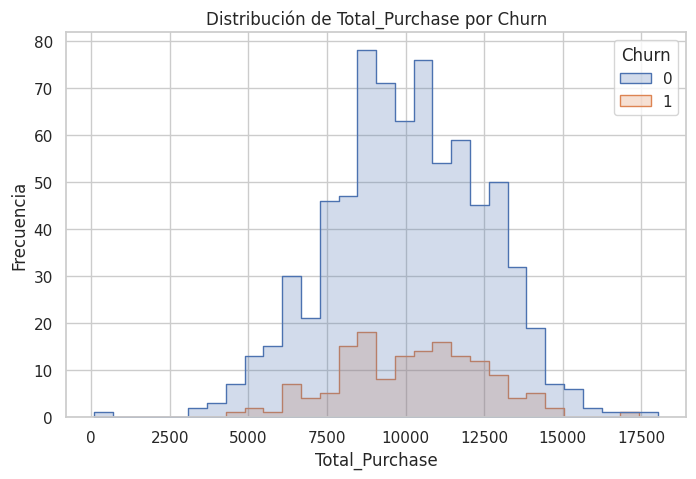

In [ ]:
# Histograma Total_Purchase por Churn
pdf_tp = df.select('Total_Purchase','Churn').toPandas()
sns.histplot(data=pdf_tp, x='Total_Purchase', hue='Churn', bins=30, kde=False, stat='count', element='step')
plt.title('Distribución de Total_Purchase por Churn')
plt.xlabel('Total_Purchase')
plt.ylabel('Frecuencia')
plt.show()

**Interpretación**

La distribución de Total_Purchase presenta un solapamiento entre clases, pero los clientes que abandonan tienden a concentrarse ligeramente en niveles de gasto más bajos. Ya que por sí sola no separa bien, aunque aporta contexto cuando se combina con Years y Num_Sites.

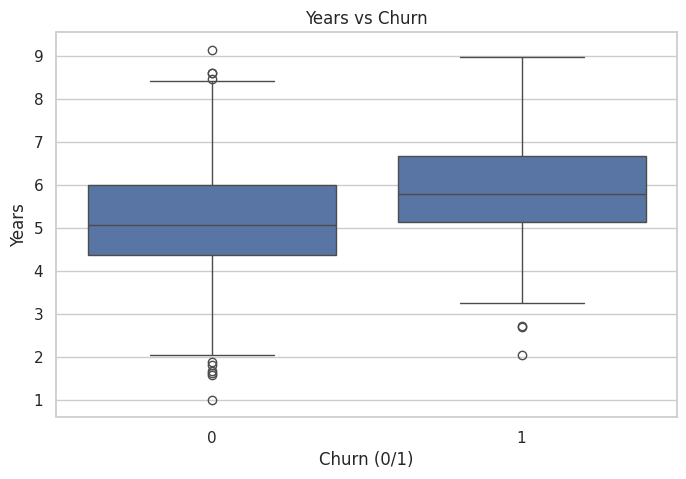

In [ ]:
# Boxplot de Years por Churn
pdf_years = df.select('Years','Churn').toPandas()
sns.boxplot(data=pdf_years, x='Churn', y='Years')
plt.title('Years vs Churn')
plt.xlabel('Churn (0/1)')
plt.ylabel('Years')
plt.show()

**Interpretación**

El boxplot sugiere que los clientes que abandonan suelen tener mayor antigüedad (Years) que quienes se mantienen ya que la mediana y buena parte del rango intercuartílico están desplazados hacia arriba para la clase de churn. Aunque la asociación lineal es moderada (corr ≈ 0.21), aporta una señal útil de que a mayor tiempo con la empresa, el riesgo tiende a aumentar si no viene acompañado de crecimiento en uso o valor. 

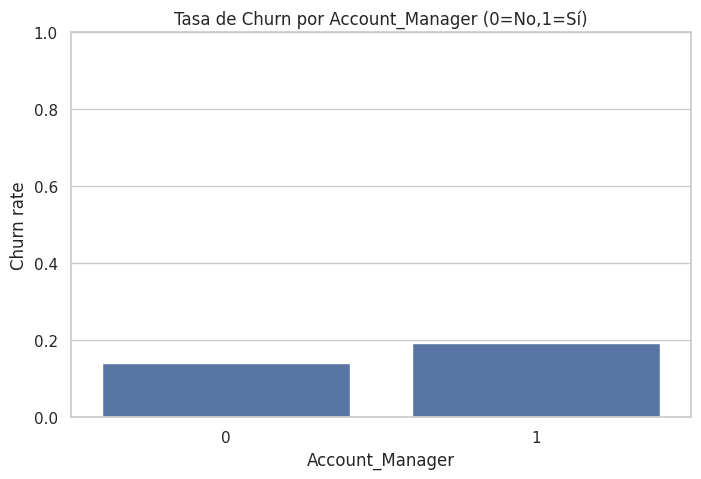

   Account_Manager    n  churn_rate
0                0  467    0.141328
1                1  433    0.193995


In [ ]:
# Tasa de churn por Account_Manager
rate_pdf = (df
    .groupBy('Account_Manager')
    .agg({'Churn':'avg','*':'count'})
    .withColumnRenamed('avg(Churn)','churn_rate')
    .withColumnRenamed('count(1)','n')
    .orderBy('Account_Manager')
    .toPandas())

sns.barplot(data=rate_pdf, x='Account_Manager', y='churn_rate')
plt.ylim(0,1)
plt.title('Tasa de Churn por Account_Manager (0=No,1=Sí)')
plt.xlabel('Account_Manager')
plt.ylabel('Churn rate')
plt.show()
print(rate_pdf)

**Interpretación**

Las tasas de churn observadas son 14.1% cuando no hay Account Manager (n=467) y 19.4% cuando sí lo hay (n=433). Esta diferencia no implica que el gerente “cause” más churn,  con frecuencia refleja un sesgo de asignación en el caso de los clientes más complejos o de mayor riesgo se les asigna un gerente. 

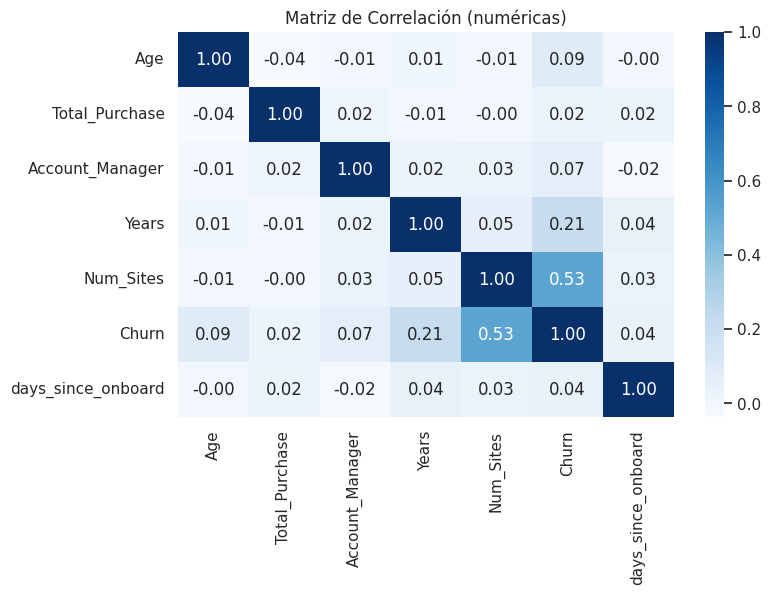

In [ ]:
# Matriz de correlación (variables numéricas) ordenada por |corr con Churn| y máscara triangular
num_cols = [c for c,t in df.dtypes if t in ('int','double')]
pdf_num = df.select(num_cols).toPandas()

corr = pdf_num.corr(numeric_only=True)
if 'Churn' in corr.columns:
    order = corr['Churn'].abs().sort_values(ascending=False).index.tolist()
    corr = corr.loc[order, order]

# Mostrar solo el triángulo inferior para legibilidad
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f', center=0, mask=mask, square=True, cbar_kws={'shrink': .8})
plt.title('Matriz de Correlación (numéricas) — ordenada por |corr con Churn|')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**Interpretación**

En la matriz se observa que la señal numérica más asociada a Churn es Num_Sites (≈ 0.53), seguida de Years (≈ 0.21), mientras que Age y Total_Purchase apenas muestran relación lineal. Account_Manager, al ser binaria, presenta una correlación punto‑biserial baja, lo que no impide que resulte útil en combinación con otras variables; y Location no aparece porque es categórica y su aporte se captura en el pipeline mediante One‑Hot Encoding. 

## **Pipeline**

In [30]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, Imputer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.functions import when, col

# 1️Definir columnas numéricas y categóricas
num_cols = [c for c, t in df.dtypes if t in ('int', 'double') and c != 'Churn']
cat_cols = [c for c, t in df.dtypes if t not in ('int', 'double') and c != 'Churn']

print('Num cols:', num_cols)
print('Cat cols:', cat_cols)

# Imputar valores numéricos si hay nulos
imputer = Imputer(inputCols=num_cols, outputCols=[c + '_imputed' for c in num_cols])
num_imputed_cols = [c + '_imputed' for c in num_cols]

# Indexar y codificar categóricas
indexers = [StringIndexer(inputCol=c, outputCol=c + '_idx', handleInvalid='keep') for c in cat_cols]
encoders = [OneHotEncoder(inputCol=c + '_idx', outputCol=c + '_ohe') for c in cat_cols]

# VectorAssembler y escalado
assembler_inputs = num_imputed_cols + [c + '_ohe' for c in cat_cols]
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol='raw_features')
scaler = StandardScaler(inputCol='raw_features', outputCol='features')

# Crear columna de peso para clase minoritaria (Churn=1)
churn_count = df.filter(col('Churn') == 1).count()
not_churn_count = df.filter(col('Churn') == 0).count()
ratio = not_churn_count / churn_count
print(f"Peso para la clase Churn=1: {ratio:.2f}")

df = df.withColumn('weight', when(col('Churn') == 1, ratio).otherwise(1.0))

# Definir Logistic Regression con weightCol
lr = LogisticRegression(
    labelCol='Churn',
    featuresCol='features',
    probabilityCol='probability',
    predictionCol='prediction',
    weightCol='weight'
)

#  Crear pipeline
stages = []
stages.append(imputer)
stages += indexers
stages += encoders
stages.append(assembler)
stages.append(scaler)
stages.append(lr)

pipeline = Pipeline(stages=stages)

# División train/test
train, test = df.randomSplit([0.8, 0.2], seed=42)
print('Train:', train.count(), 'Test:', test.count())




Num cols: ['Age', 'Total_Purchase', 'Account_Manager', 'Years', 'Num_Sites', 'days_since_onboard']
Cat cols: ['Location']
Peso para la clase Churn=1: 5.00
Train: 754 Test: 146


## **Training**

In [31]:
# Entrenar modelo
model = pipeline.fit(train)

# Predicción en test
preds = model.transform(test)

# Evaluación
evaluator_auc = BinaryClassificationEvaluator(labelCol='Churn', rawPredictionCol='probability', metricName='areaUnderROC')
auc = evaluator_auc.evaluate(preds)
print(f"AUC en test: {auc:.4f}")

evaluator_acc = MulticlassClassificationEvaluator(labelCol='Churn', predictionCol='prediction', metricName='accuracy')
acc = evaluator_acc.evaluate(preds)
print(f"Accuracy en test: {acc:.4f}")

# Matriz de confusión
preds.groupBy('Churn', 'prediction').count().orderBy('Churn', 'prediction').show()

AUC en test: 0.9371
Accuracy en test: 0.8767
+-----+----------+-----+
|Churn|prediction|count|
+-----+----------+-----+
|    0|       0.0|  103|
|    0|       1.0|   13|
|    1|       0.0|    5|
|    1|       1.0|   25|
+-----+----------+-----+



## **Gráficos de evaluación (test)**

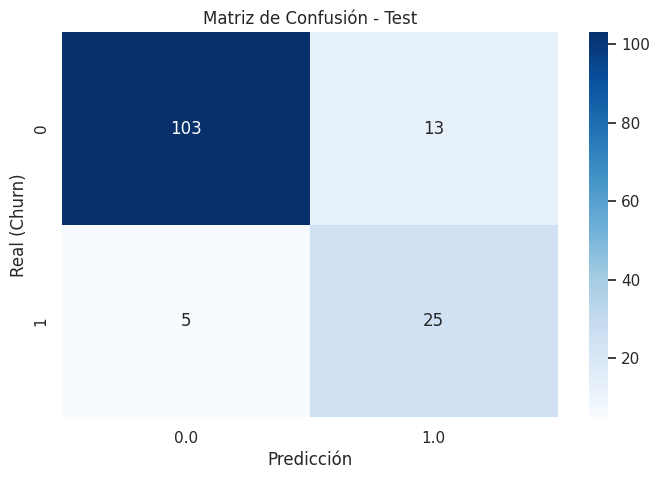

prediction  0.0  1.0
Churn               
0           103   13
1             5   25


In [45]:
# Matriz de confusión (heatmap)
import pandas as pd
from pyspark.sql import functions as F

cm_df = preds.groupBy('Churn','prediction').count().toPandas()
# Asegurar todas las celdas (0/1)
pivot = cm_df.pivot(index='Churn', columns='prediction', values='count').fillna(0).astype(int)
# Ordenar por filas/columnas 0,1
pivot = pivot.reindex(index=[0,1], columns=[0.0,1.0])

sns.heatmap(pivot, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real (Churn)')
plt.title('Matriz de Confusión - Test')
plt.show()
print(pivot)

**Interpretación**

- Resultados test: TN=103, FP=13, FN=5, TP=25 (N=146).
- Métricas clave (umbral ≈ 0.50):
  - Accuracy ≈ 0.877
  - Precision positiva ≈ 0.658
  - Recall/TPR (sensibilidad) ≈ 0.833
  - Especificidad/TNR ≈ 0.888 (FPR ≈ 0.112)
  - F1 ≈ 0.736 | Balanced accuracy ≈ 0.861

En este caso se observa que el modelo marca como “riesgo” al 26.0% de los clientes (38/146) y con ello captura el 83.3% de los abandonos (25/30). Dado que la prevalencia en test es ≈ 20.5%, la precisión del modelo implica un lift ≈ 3.2× frente a contactar aleatoriamente.

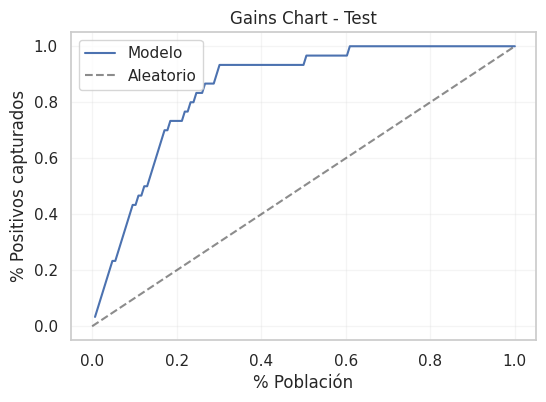

Captura en top 10%: 43.3%
Captura en top 20%: 73.3%


In [47]:
# Gains chart (cumulative capture)
import numpy as np
import pandas as pd

def _prob1(v):
    try:
        return float(v[1])
    except Exception:
        return None

pp = preds.toPandas()
pp['prob_1'] = pp['probability'].apply(_prob1)
pp = pp[['prob_1','Churn']].dropna().sort_values('prob_1', ascending=False).reset_index(drop=True)

N = len(pp)
P = pp['Churn'].sum()
pp['rank'] = np.arange(1, N+1)
pp['population_rate'] = pp['rank']/N
pp['cum_positives'] = pp['Churn'].cumsum()
pp['cum_capture_rate'] = pp['cum_positives'] / P if P>0 else 0

plt.figure(figsize=(6,4))
plt.plot(pp['population_rate'], pp['cum_capture_rate'], label='Modelo')
plt.plot([0,1],[0,1],'k--',alpha=0.5,label='Aleatorio')
plt.xlabel('% Población')
plt.ylabel('% Positivos capturados')
plt.title('Gains Chart - Test')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

# Mostrar puntos de referencia 10% y 20%
for frac in [0.1, 0.2]:
    k = max(1, int(np.ceil(N*frac)))
    cap = pp.iloc[:k]['Churn'].sum()/P if P>0 else 0
    print(f'Captura en top {int(frac*100)}%: {cap*100:.1f}%')

**Interpretación**

La curva del modelo se mantiene claramente por encima de la línea aleatoria. Esto indica que, al ordenar a los clientes por su probabilidad de abandono y priorizar la intervención sobre quienes tienen mayor score, se captura una fracción mucho mayor de casos positivos con el mismo esfuerzo. 

## **Nuevos Clientes**

In [48]:
df_new.show(7, truncate=False)

+--------------+----+--------------+---------------+-----+---------+-------------------+---------------------------------------------------------+----------------+---------------+------------------+
|Names         |Age |Total_Purchase|Account_Manager|Years|Num_Sites|Onboard_date       |Location                                                 |Company         |Onboard_date_dt|days_since_onboard|
+--------------+----+--------------+---------------+-----+---------+-------------------+---------------------------------------------------------+----------------+---------------+------------------+
|Andrew Mccall |37.0|9935.53       |1              |7.71 |8.0      |2011-08-29 18:37:54|38612 Johnny Stravenue Nataliebury, WI 15717-8316        |King Ltd        |2011-08-29     |5172              |
|Michele Wright|23.0|7526.94       |1              |9.28 |15.0     |2013-07-22 18:19:54|21083 Nicole Junction Suite 332, Youngport, ME 23686-4381|Cannon-Benson   |2013-07-22     |4479              |
|Jere

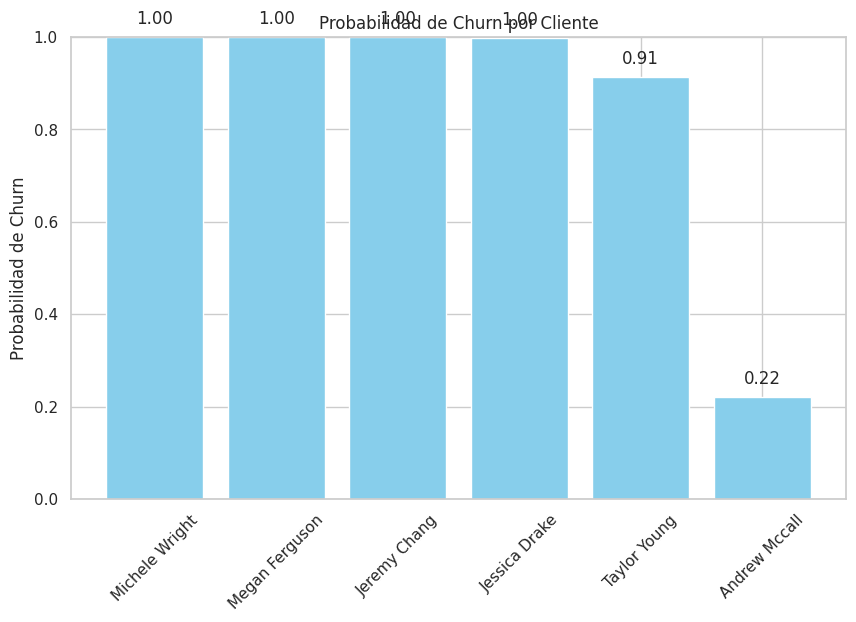

            Names  churn_probability
1  Michele Wright           1.000000
3  Megan Ferguson           1.000000
2    Jeremy Chang           0.999996
5   Jessica Drake           0.998396
4    Taylor Young           0.912932
0   Andrew Mccall           0.221259


In [49]:
# Aplicar pipeline al df_new
preds_new = model.transform(df_new)

# Extraer probabilidad de churn (probabilidad de 1)
get_prob_1 = udf(lambda v: float(v[1]) if v is not None else None, DoubleType())
preds_new = preds_new.withColumn('churn_probability', get_prob_1(col('probability')))

# Convertir a Pandas solo con Names y churn_probability
preds_pd = preds_new.select('Names', 'churn_probability').toPandas()
preds_pd = preds_pd.sort_values('churn_probability', ascending=False)

# Graficar
plt.figure(figsize=(10,6))
plt.bar(preds_pd['Names'], preds_pd['churn_probability'], color='skyblue')
plt.title('Probabilidad de Churn por Cliente')
plt.ylabel('Probabilidad de Churn')
plt.ylim(0,1)

# Etiquetas encima de las barras
for i, prob in enumerate(preds_pd['churn_probability']):
    plt.text(i, prob + 0.02, f'{prob:.2f}', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.show()

# Mostrar tabla
print(preds_pd)


## **Discusión de resultados**


En test, el modelo de regresión logística del pipeline de Spark muestra una separabilidad alta (AUC ≈ 0.94) y un buen desempeño global (accuracy ≈ 0.88). A partir de la matriz de confusión se obtienen: TN=103, FP=13, FN=5, TP=25 (N=146), con precisión positiva ≈ 0.66, recall/TPR ≈ 0.83, especificidad/TNR ≈ 0.89, F1 ≈ 0.74 y balanced accuracy ≈ 0.86. Con el umbral por defecto (~0.50) el modelo etiqueta como riesgo ~26% de la base de test (38/146) y captura ~83% de los abandonos (25/30), lo que se traduce en un lift ≈ 3.2× frente a contactar clientes al azar.

El Gains chart se mantiene claramente por encima de la línea aleatoria, confirmando que ordenar por probabilidad permite capturar una mayor fracción de abandonos con el mismo esfuerzo; en los primeros deciles (10–20%) ya se concentra una proporción relevante de casos positivos. En el EDA, Num_Sites presenta la señal numérica más fuerte con Churn (≈ 0.53) y Years una asociación moderada (≈ 0.21), mientras que Age y Total_Purchase aportan poca señal lineal; la diferencia de churn por Account_Manager probablemente refleja sesgo de asignación y no causalidad. La matriz de correlaciones es lineal (Pearson) y no implica causalidad; variables categóricas se capturan vía One‑Hot en el pipeline.


## **Conclusión**


El pipeline en Spark logra un modelo con AUC ≈ 0.94 y un lift ≈ 3.2× que permite priorizar de forma efectiva a los clientes con mayor riesgo de abandono; con un umbral alrededor de 0.50 se contacta ~26% de la base capturando ~83% de los abandonos, lo que apoya asignar Account Managers primero a ese segmento. Para pasar a producción, fijar el umbral según capacidad y costo/beneficio, validar el efecto con A/B, y robustecer con tuning, calibración y monitoreo de desempeño en el tiempo.